In [1]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [3]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)
    osm.mean_t(df,index,fdf)
    osm.std_whiff(df,index,fdf)

In [4]:
def low_pass_filter(dataframe,cutoff):
    fs=200
    nyq=fs*0.5
    cutoff_freq=cutoff

    sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
    filtered = signal.sosfilt(sos, dataframe.odor)
    dt = dataframe.master_time[1]-dataframe.master_time[0]

    time = []
    time.append(0)
    for i in range(1,len(dataframe)):
        time.append(time[i-1]+dt)   
    dataframe['time'] = time

    dataframe['filtered_odor']=filtered

    return dataframe

In [5]:
# cutoff=np.array([0.1,0.2,0.5,1,2,4,6,8,10,15,20,40])
# cutoff=np.array([50,60,70,80,90])

In [10]:
df = pd.read_hdf(dir+'Forest/ForestMASigned.h5')
# df.distance_from_source=df.distance_from_source*df.xsign
# df.nearest_from_streakline=df.nearest_from_streakline*df.ysign

In [11]:
np.seterr(divide = 'ignore') 
index = osm.get_index_forest(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

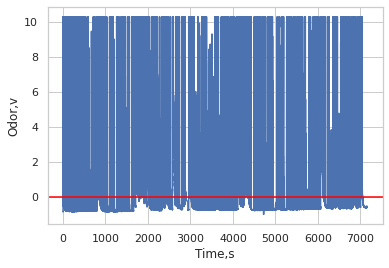

In [23]:
plt.plot(df.time,df.odor)
plt.xlabel('Time,s')
plt.ylabel('Odor,v')
plt.axhline(y=0, color='red')

In [9]:
df['whiff_duration_plot']=np.zeros(len(df))
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    val=0
    val = (dt*(len(index[i])))
    df.whiff_duration_plot.loc[index[i]] = val
    i+=1

In [10]:
df['whiff_concentration_plot']=np.zeros(len(df))
mean_odor=np.mean(df.odor[607980:608103])
df.whiff_concentration_plot[607980:608103]=mean_odor

In [132]:
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    val=0
    val = (dt*(len(index[i])))
    df.whiff_duration_plot.loc[index[i]] = val
    i+=1

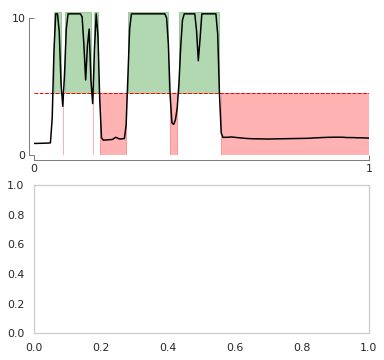

In [237]:
f,ax=plt.subplots(2,1,figsize=(6,6))
limit=[4002.05,4003]
ax[0].axhline(4.5, linestyle='--', c='red',linewidth=1)
ax[0].plot(df.time,df.odor, c='black')

#for shading
x = []
for i in range(len(index)):
    if math.isclose(df.time.loc[index[i][0]],4002,abs_tol=1):
        x.append(i)
        
for i in range(1,len(x)):
    ax[0].axvspan(xmin=df.time.loc[index[x[i]][0]],xmax= df.time.loc[index[x[i]][-1]],ymin=0.42,ymax=0.97,  alpha=0.3, color='green')
i=0
for i in range(1,len(x)-1):
    ax[0].axvspan(xmin=df.time.loc[(index[x[i]][-1])+1],xmax= df.time.loc[(index[x[i+1]][0])-1],ymin=0,ymax=0.42,  alpha=0.3, color='red')

ax[0].axvspan(xmin=df.time.loc[(index[x[-1]][-1])+1],xmax= df.time.loc[(index[x[-1]][-1])+100],ymin=0,ymax=0.42,  alpha=0.3, color='red')


ax[0].set_xlim(limit)

mpl_functions.adjust_spines(ax[0],['left','bottom'],
                            spine_locations={'left': 5, 'bottom': 5}, 
                            smart_bounds=True,
                            xticks=limit,
                            yticks=[0,10],
                            linewidth=0.5)

ax[0].grid(False)
ax[0].set_xticklabels([0,1])

# ax[1].plot(df.time,df.encounter_frequency, c='black')


# ax[1].set_xlim(limit)
# ax[1].set_ylim(0,0.5)
# mpl_functions.adjust_spines(ax[1],['left','bottom'],
#                             spine_locations={'left': 5, 'bottom': 5}, 
#                             smart_bounds=True,
#                             xticks=limit,
#                             yticks=[0,0.5],
#                             linewidth=0.5)

# ax[1].set_xticklabels([0,0.5])
ax[1].grid(False)

In [ ]:
## f,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(fdf.log_avg_dist_from_source_signed, fdf.mean_ef, c=fdf.mean_concentration)
ax.set_xlabel('Distance from source (log)')
ax.set_ylabel('Whiff Frequency')
ax.grid(False)

In [15]:
q = 'log_avg_dist_from_source_signed >=0.5 & log_avg_dist_from_source_signed<1'
fdf_test=fdf.query(q)

In [32]:
xmin=np.min(fdf_test.log_avg_dist_from_source_signed)
xmax=np.max(fdf_test.log_avg_dist_from_source_signed)
ymin=np.min(fdf_test.mean_ef)
ymax=np.max(fdf_test.mean_ef)

In [34]:
x_bins = np.linspace(xmin, xmax, 50)
y_bins = np.linspace(ymin, ymax, 20)

/tmp/ipykernel_43714/1958382134.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.hist2d(fdf_test.log_avg_dist_from_source_signed, fdf_test.mean_ef,bins =[x_bins, y_bins])


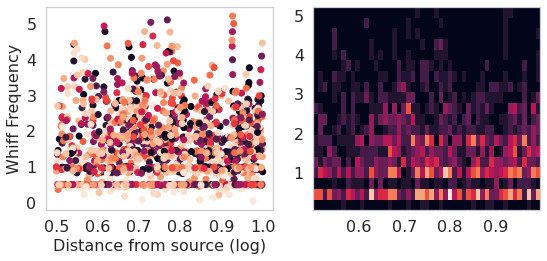

In [37]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
ax1.scatter(fdf_test.log_avg_dist_from_source_signed, fdf_test.mean_ef, c=fdf_test.mean_concentration)
ax1.grid(False)
ax1.set_xlabel('Distance from source (log)')
ax1.set_ylabel('Whiff Frequency')
ax2.hist2d(fdf_test.log_avg_dist_from_source_signed, fdf_test.mean_ef,bins =[x_bins, y_bins])

f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 16)
plt.show()

In [16]:
# fdf.to_hdf(dir+'NotWindy/NotWindyMASigned_8.h5', key='fdf', mode='w')

In [7]:
# np.seterr(divide = 'ignore') 
# for i in range(len(cutoff)):
#     desert = pd.concat([nwindy,windy])
#     desert.reset_index(inplace=True,drop=True)
#     lpf_desert = low_pass_filter(desert,cutoff[i])
    
#     index = osm.get_index_filtered(lpf_desert)
#     fdf = pd.DataFrame()
#     get_statistics(lpf_desert,index,fdf)
#     dir = '~/DataAnalysis/data/Sprints/LpfAnalysis/'
#     fdf.to_hdf(dir+'desert_'+str(cutoff[i])+'.h5', key='fdf', mode='w')

In [28]:
# f,ax=plt.subplots(1,1,figsize=(4,4))
# n, bins, patches = ax.hist((df.odor), 20, density=True, facecolor='b', alpha=0.75)
# ax.grid(False)
# mpl_functions.adjust_spines(ax,['left','bottom'],
#                            spine_locations={}, 
#                            smart_bounds=True,
#                            yticks=[0,.8,1.6],
#                            xticks=[0,5,10],
#                            linewidth=1)

# ax.set_xlabel('Odor Concentration, v')
# ax.set_ylabel('Frequency')
# ax.set_title("Odor Concentration\nHistogram, WS>3.5m/s")
# f.tight_layout()
# mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/HistWindy.jpeg', dpi=300, bbox_inches = "tight")
# # print(n,bins,patches)

In [33]:
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
# fdf.to_hdf(dir+'NotWindy/NotWindyStatsTime.h5', key='fdf', mode='w')

### LOW PASS FILTER ANALYSIS

In [58]:
dt = df.time[1]-df.time[0]

In [7]:
l1 = list(np.arange(0.01,0.1,0.01))
l2 = [1,5,10,15,20,25,30,35,40]
kernel_size = l1+l2

m_ef=[]
for i in range(0,len(kernel_size)):
    m_ef.append(osm.encounter_frequency(df,index,fdf,1,kernel_size[i])) 
    

sl = []
r = []
for i in range(len(m_ef)):
#     print(i)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source_signed,m_ef[i])
    sl.append(slope)
    r.append(r_value)
    
for i in range(len(m_ef)):
    fdf['mean_ef_'+str(i)]=m_ef[i]

### Odor Statistics Calculation Plots

In [7]:
# f,(ax)=plt.subplots(4,1,figsize=(8.5,11))
# ##plots
# ax[0].plot(df.time,df.odor)
# # ax[0].axhline(4.5, linestyle='dashed', color='r')
# ax[0].set_xlim(1535,1540)
# ax[1].plot(df.time,df.whiff_plot)
# ax[1].set_xlim(1535,1540)
# # ax[2].plot(df.time,df.efreq)
# # ax[2].set_xlim(1535,1540)
# ax[2].plot(df.time, df.encounter_frequency)
# ax[2].set_xlim(1535,1540)
# ax[3].plot(df.time,df.ma_fraction)
# ax[3].set_xlim(1535,1540)

# ## adjust spines and grids
# for i in range(4):
#     ax[i].grid(False)
    
# mpl_functions.adjust_spines(ax[0],['left'],spine_locations={},smart_bounds=True, yticks=[0,10],linewidth=1)

# for i in range(1,3):
#     mpl_functions.adjust_spines(ax[i],['left'],spine_locations={},smart_bounds=True, yticks=[0,1],linewidth=1)

# mpl_functions.adjust_spines(ax[2],['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,5],linewidth=1)

# mpl_functions.adjust_spines(ax[3],['left', 'bottom'],spine_locations={},
#                             smart_bounds=True,yticks=[0,1],linewidth=1)

# ## label
# ax[0].set_ylabel('Odor, V')
# ax[1].set_ylabel('Whiff\nDuration, V')
# # ax[2].set_ylabel('Encounter\nOnsets')
# ax[2].set_ylabel('Encounter\nFrequency,Hz')
# ax[3].set_ylabel('Moving\nAverage, V')
# ax[3].set_xlabel('Time, s')


# f.suptitle("Odor Statistics Calculation\nOdor Threshold > 4.5V")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/OdorStat.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Plots

In [71]:
avg_dist_along_streakline = []
i = 0
while i<len(index):
    avg_dist_along_streakline.append(np.mean(df.distance_from_source_a[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_along_streakline

In [6]:
# fdf=(fdf-fdf.mean())/fdf.std()
# nfdf=(fdf-fdf.min())/(fdf.max()-fdf.min())

In [7]:
# q = 'length_of_encounter >=0.1'
# fdf=fdf.query(q)

In [8]:
# q1='log_avg_dist_from_source_signed<0'
# fdf1=nfdf.query(q1)
# q2='log_avg_dist_from_source_signed>0'
# fdf2=nfdf.query(q2)

In [14]:
fdf1=pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf2=pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf3=pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

In [15]:
dataframe=pd.concat([fdf1,fdf2,fdf3])
dataframe.reset_index(inplace=True, drop=True)

In [19]:
dataframe.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source', 'avg_xsign',
       'avg_dist_from_streakline', 'log_avg_dist_from_source_signed',
       'mean_concentration', 'avg_parallel_encounter',
       'avg_perpendicular_encounter', 'avg_parallel_intermittency',
       'avg_perpendicular_intermittency', 'length_of_encounter',
       'odor_intermittency', 'log_whiff', 'log_blank',
       'speed_at_intermittency', 'speed_at_encounter', 'mean_ef', 'mean_ma',
       'mean_time', 'type', 'std_whiff', 'whiff_ma'],
      dtype='object')

In [25]:
a = dataframe.std_whiff
b = dataframe.log_avg_dist_from_source_signed
# mask = ~np.isnan(fdf.log_avg_dist_from_source)
# mask = np.isfinite(fdf.log_avg_dist_from_source) & np.isfinite(a)
slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
# slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source[mask],a[mask])

# if p_value<=0.05:
#     print ('significant')
#     print('r2_value:', "{:e}".format(r_value**2))
#     print("p_value:", "{:e}".format(p_value))

# else:
#     print ('insignificant')
#     print('r2_value:', "{:e}".format(r_value**2))
#     print("p_value:", "{:e}".format(p_value))

r_value**2

0.005232501116052007

In [8]:
# fdf1['mean_ef_log']=np.random.lognormal(fdf1.mean_ef)
# fdf2['mean_ef_log']=np.random.lognormal(fdf2.mean_ef)
# fdf3['mean_ef_log']=np.random.lognormal(fdf3.mean_ef)

/tmp/ipykernel_7244/3879475265.py:59: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])


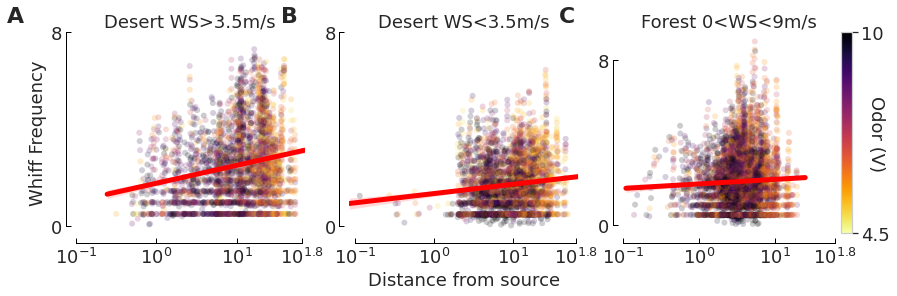

In [12]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))
line_width=0.5                    
var1 = ax1.scatter(fdf1.log_avg_dist_from_source_signed, fdf1.mean_ef, 
                   c=fdf1.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)
g1 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=fdf1, 
            ax=ax1, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.8],
                            yticks=[0,8],
                            linewidth=1)
ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

##########
var2 = ax2.scatter(fdf2.log_avg_dist_from_source_signed, fdf2.mean_ef, 
                   c=fdf2.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=fdf2, 
            ax=ax2, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.8],
                            yticks=[0,8],
                            linewidth=1)
# ax2.yaxis.set_label_coords(-0.23, 0.5)
ax2.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

##########


var3 = ax3.scatter(fdf3.log_avg_dist_from_source_signed, fdf3.mean_ef, 
                   c=fdf3.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=fdf3, 
            ax=ax3, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)


mpl_functions.adjust_spines(ax3,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.8],
                            yticks=[0,8],
                            linewidth=1)
ax3.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4.5', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor (V)', rotation=-90, labelpad=-5)

ax1.set_ylabel('Whiff Frequency')
ax2.set_xlabel('Distance from source')
ax1.set_title('Desert WS>3.5m/s')
ax2.set_title('Desert WS<3.5m/s')
ax3.set_title('Forest 0<WS<9m/s')

ax=[ax1,ax2,ax3]

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
for i in range(len(ax)):
    ax[i].text(-0.3, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold', fontsize=22)

# f.savefig('../../Figure/WFAll.jpeg', dpi=300, bbox_inches = "tight")

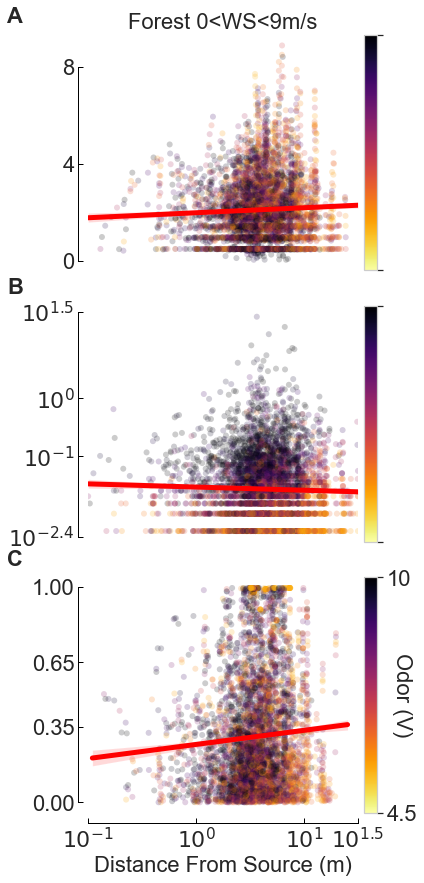

In [163]:
f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(6,12))

color_whiff = 'red'
color_ef ='red'
color_ma = 'red'


var1 = ax1.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_ef, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)
g1 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=dataframe, 
            ax=ax1, line_kws={'color':color_ef,'linewidth':5}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
# ax1.set_xlabel('Distance From Source (m)')
# ax1.set_ylabel('Whiff Frequency (Hz)')

mpl_functions.adjust_spines(ax1,['left'],
                            spine_locations={}, 
                            smart_bounds=True,     
                            yticks=[0,4,8],
                            linewidth=1)
ax1.yaxis.set_label_coords(-0.23, 0.5)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical', ticks=[4, 10])
cbar1.solids.set(alpha=1)
cbar1.ax.set_yticklabels([])


########## subplot 2 #############
var2 = ax2.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.log_whiff, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 =sns.regplot(x="log_avg_dist_from_source_signed",y="log_whiff", data=dataframe, 
            ax=ax2, line_kws={'color':color_whiff,'linewidth':5}, scatter=False, truncate=True)
g2.set(xlabel=None, ylabel=None)

# ax2.set_ylabel('Whiff Duration (s)')
mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={}, 
                            smart_bounds=True,
                           
                            yticks=[-2.4,-1,0,1.5],
                            linewidth=1)
ax2.yaxis.set_label_coords(-0.23, 0.5)
ax2.set_yticklabels([r'$10^{-2.4}$',r'$10^{-1}$', r'$10^0$', r'$10^{1.5}$'])

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.08)
cbar2=f.colorbar(var2, cax=cax2, orientation = 'vertical', ticks=[4, 10])
cbar2.solids.set(alpha=1)
cbar2.ax.set_yticklabels([])

########## subplot 1 #############

var3 = ax3.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_ma, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3=sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ma", data=dataframe, 
            ax=ax3, line_kws={'color':color_ma,'linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_xlabel('Distance From Source (m)')
# ax3.set_ylabel('Whiff Moving\nAverage (V)')
mpl_functions.adjust_spines(ax3,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.5],
                            yticks=[0,0.35,0.65,1],
                            linewidth=1)
ax3.yaxis.set_label_coords(-0.23, 0.5)
ax3.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.5}$'])


divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4.5', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor (V)', rotation=-90, labelpad=-5)


########## subplot 3 #############
ax1.set_title('Forest 0<WS<9m/s')
# f.suptitle('Desert\n Wind Speed > 3m/s \n -ve x-axis')
# f.suptitle("Forest\n0>WS>9m/s\n +ve x-axis")
ax=[ax1,ax2,ax3]
for i in range(len(ax)):
     ax[i].text(-0.3, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold')


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)

# f.savefig('../../Figure/Forest.jpeg', dpi=300, bbox_inches = "tight")

## Box Cox Transform

In [6]:
fitted_ef, fitted_lambda1 = stats.boxcox(fdf.mean_ef)
fdf.mean_ma=fdf.mean_ma+0.1
fitted_ma, fitted_lambda2 = stats.boxcox(fdf.mean_ma)
fitted_wd, fitted_lambda3 = stats.boxcox(fdf.length_of_encounter)

trans_df=pd.DataFrame()
trans_df['mean_ef']=fitted_ef
trans_df['mean_ma']=fitted_ma
trans_df['log_whiff']=fitted_wd
trans_df['avg_parallel_encounter'] =fdf.avg_parallel_encounter
trans_df['avg_perpendicular_encounter'] =fdf.avg_perpendicular_encounter
trans_df['log_avg_dist_from_source_signed']=fdf.avg_dist_from_source*fdf.avg_xsign
trans_df['mean_concentration']=fdf.mean_concentration

In [15]:
dat=fdf

In [16]:
whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
moving_avg = smf.ols(formula='mean_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()

In [17]:
dat['whiff_frequency_resid']=whiff_frequency.resid
dat['whiff_duration_resid'] = whiff_duration.resid
dat['moving_avg_resid'] = moving_avg.resid

In [18]:
# q1='log_avg_dist_from_source<0'
# fdf1=fdf.query(q1)
# q2='log_avg_dist_from_source>=0'
# fdf2=fdf.query(q2)

In [19]:
distance=smf.ols(formula='log_avg_dist_from_source_signed~ whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=dat).fit()
print(distance.summary())

                                   OLS Regression Results                                  
Dep. Variable:     log_avg_dist_from_source_signed   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.024
Method:                              Least Squares   F-statistic:                     29.18
Date:                             Thu, 28 Apr 2022   Prob (F-statistic):           1.26e-18
Time:                                     08:13:47   Log-Likelihood:                -882.71
No. Observations:                             3491   AIC:                             1773.
Df Residuals:                                 3487   BIC:                             1798.
Df Model:                                        3                                         
Covariance Type:                         nonrobust                                         
                            coef    std err          t      P>|t|      [0.025   

In [20]:
print("WF - p_value: " "{:e}".format(distance.pvalues.whiff_frequency_resid))
print("WD - p_value: " "{:e}".format(distance.pvalues.whiff_duration_resid))
print("WMA - p_value: " "{:e}".format(distance.pvalues.moving_avg_resid))

WF - p_value: 4.070496e-06
WD - p_value: 6.985597e-04
WMA - p_value: 2.982506e-07


Box Cox improves the heteroskedacity in Lower wind speed dataset, BP Test p-value goes from $3.001e^{-03}$ to $3.979e^{-01}$ , however $R^2$ and model significance $f-pvalue$ lowers. Below shows the distribution after applying log transform and box-cox transform 

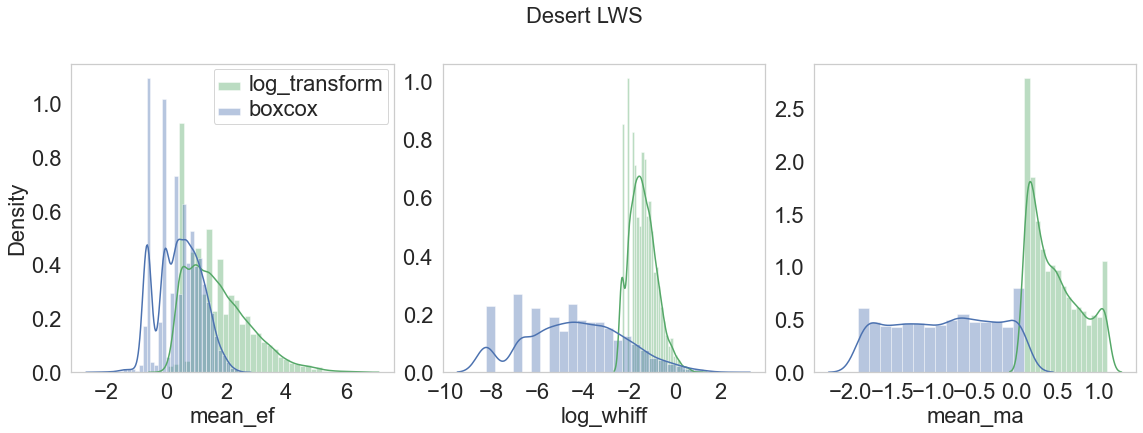

In [48]:
f,ax=plt.subplots(1,3,figsize=(16,6))
sns.distplot(fdf.mean_ef, color='g', ax=ax[0], label='log_transform')
sns.distplot(trans_df.mean_ef, ax=ax[0], label='boxcox')

sns.distplot(fdf.log_whiff, color='g', ax=ax[1])
sns.distplot(trans_df.log_whiff, ax=ax[1])

sns.distplot(fdf.mean_ma, color='g', ax=ax[2])
sns.distplot(trans_df.mean_ma, ax=ax[2])

for i in range(3):
    ax[i].grid(False)

ax[0].legend()        

ax[1].set_ylabel('')
ax[2].set_ylabel('')
f.suptitle('Desert LWS', fontsize=18)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 22)

### Normality Analysis

In [21]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(distance.resid)
lzip(name, test)

[('Jarque-Bera', 118.97247302095705),
 ('Chi^2 two-tail prob.', 1.4637123403001896e-26),
 ('Skew', -0.4037700952510633),
 ('Kurtosis', 3.407177225403563)]

### Breusch Pagan Test

In [22]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(distance.resid, distance.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 13.930256198094515),
 ('p-value', 0.003001639562512519),
 ('f-value', 4.656679996074543),
 ('f p-value', 0.0029821982725497273)]

###### Diagnostic plots

Let's check that the assumptions of the model have not been violated. Specifically, we look to see:

* the residuals are well distributed (standardized residuals vs predicted)
* the residuals follow a normal distribution (shapiro-wilks test) since we are using a linear model, not generalized
* check the heteroscedasticity (Q-Q plot)
* the variance is not a function of the output (observed vs predicted)
As with the $R^2$ situation, we will look at predictions and residuals that include the fixed and random effects, or only the fixed, since we are using a mixed effects linear model.

Some useful stuff:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/


### Actual vs Predicted

The scatter data should fall evenly around the red line, without any major patterns.


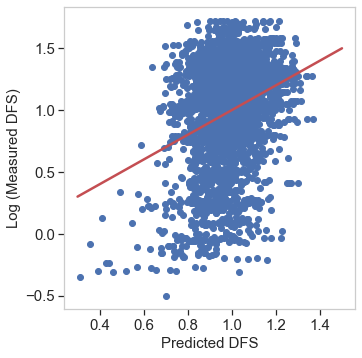

In [211]:
f,ax=plt.subplots(1,1,figsize=(5,5))
b, a = np.polyfit(distance.fittedvalues,fdf.log_avg_dist_from_source_signed, deg=1)
xseq = np.linspace(.3, 1.5, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Log (Measured DFS)')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, fdf.log_avg_dist_from_source_signed)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/ActPred.jpeg', dpi=300, bbox_inches = "tight")


### Standardized residuals

Standardized residuals = (observed - expected) / std_dev(expected)

The scatter should be evenly distributed around the red line, without any obvious patterns, like growing or shrinking residuals as a function of predicted value.



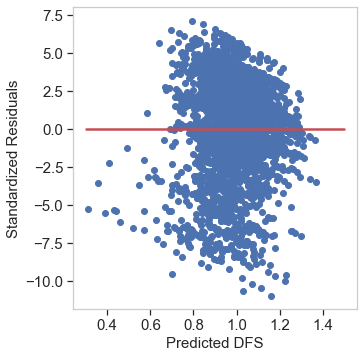

In [212]:
f,ax=plt.subplots(1,1,figsize=(5,5))
standardized_residuals = (fdf.log_avg_dist_from_source_signed - distance.fittedvalues) / np.std(distance.fittedvalues)
b, a = np.polyfit(distance.fittedvalues, standardized_residuals, deg=1)
xseq = np.linspace(.3, 1.5, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Standardized Residuals')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, standardized_residuals)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/StdResid.jpeg', dpi=300, bbox_inches = "tight")

### Residual Analysis
### Q-Q plot

The scatter should follow the red line, especially in the middle. Looks pretty good here. The plots shows there is a central peak in distribution



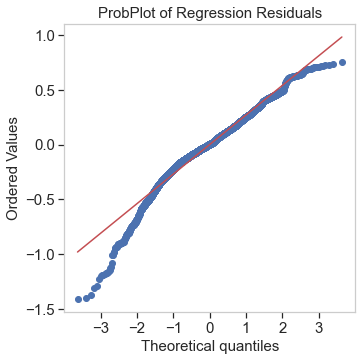

In [198]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.grid(False)
stats.probplot(distance.resid,plot=ax)
f.tight_layout(pad=1)
# f.suptitle('Q-Q Plot')
ax.set_title('ProbPlot of Regression Residuals')
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/qq.jpeg', dpi=300, bbox_inches = "tight")


### Normality of residuals

The residuals should be normally distributed in this case, because we are using a linear model that assumes that the residuals are going to be normally distributed.

Not ideal here, there seem to be more small residuals than a normal distribution would predict.

** for hist plots
density=True represents the frequency distribution

density=False represents the probability density distribution


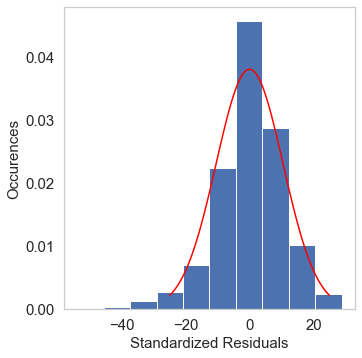

In [200]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.hist(standardized_residuals, density=True, stacked=True)

rv = stats.norm(0, np.std(standardized_residuals))
x = np.linspace(-25,25,100)
pdf = rv.pdf(x)
ax.plot(x, pdf, color='red')
ax.set_xlabel('Standardized Residuals')
ax.set_ylabel('Occurences')
ax.grid(False)
# ax.set_title('Conditional (fixed and random effects)')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/OccuResid.jpeg', dpi=300, bbox_inches = "tight")